In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

import qiskit
from qiskit.tools.visualization import circuit_drawer, plot_histogram, plot_state
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QuantumProgram
from qiskit import available_backends, execute

In [2]:
%load_ext autoreload
%autoreload 2
import utils

In [72]:
def most_probable_result(result):
    max_tuple = max(result.get_counts().items(), key=lambda x: x[1])
    return max_tuple[0]

In [152]:
n = 3  # Number of qubits.
string = [1, 0, 1]

n_iter = int(np.sqrt(n) + 1) # iterate sqrt(N) times
# n_iter = 2

# qc = utils.build_grover_search_qc(n, n_iter, string)

# phone = QuantumRegister(n, name='phone')
# qc.add(phone)
# ansphone = ClassicalRegister(n, name='ansphone')
# qc.add(ansphone)

# qc.cx(qc.get_qregs()['fin'], qc.get_qregs()['phone'])

# qc.measure(qc.get_qregs()['fin'], qc.get_cregs()['ans'])
# qc.measure(qc.get_qregs()['phone'], qc.get_cregs()['ansphone'])

In [75]:
# if measure:
#     result = execute(qc, backend='local_qasm_simulator',
#                           shots=8192).result()
#     plot_histogram(result.get_counts())
# else:
#     statevector = execute(qc, backend='local_statevector_simulator_py',
#                           shots=1).result().get_data()['statevector']
#     statevector = statevector[:2 ** n]
#     utils.plot_statevector(statevector)

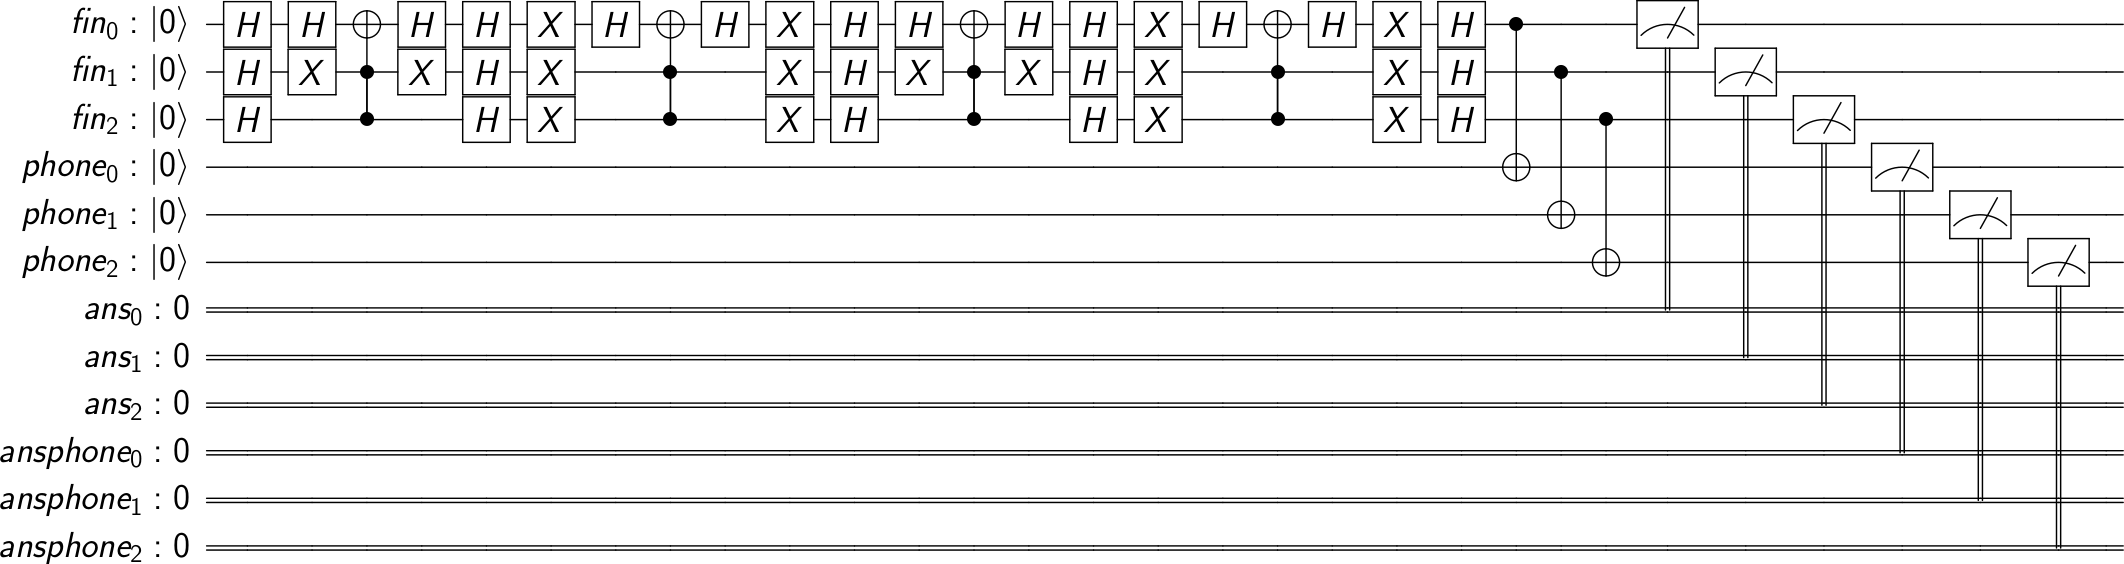

In [76]:
circuit_drawer(qc)

In [149]:
def plot_histogram(data, title=None, number_to_keep=False, name_mapping=None):
    """Plot a histogram of data.

    data is a dictionary of  {'000': 5, '010': 113, ...}
    number_to_keep is the number of terms to plot and rest is made into a
    single bar called other values
    """
    if number_to_keep is not False:
        data_temp = dict(Counter(data).most_common(number_to_keep))
        data_temp["rest"] = sum(data.values()) - sum(data_temp.values())
        data = data_temp

    labels = sorted(data)
    values = np.array([data[key] for key in labels], dtype=float)
    pvalues = values / sum(values)
    numelem = len(values)
    ind = np.arange(numelem)  # the x locations for the groups
    width = 0.35  # the width of the bars
    _, ax = plt.subplots()
    rects = ax.bar(ind, pvalues, width, color='seagreen')
    # add some text for labels, title, and axes ticks
    ax.set_ylabel('Вероятность', fontsize=12)
    ax.set_xticks(ind)
    
    if name_mapping:
        n = len(list(name_mapping.keys())[0])
        labels = [name_mapping[x[-n:]] for x in labels]
    
    if title:
        ax.set_title(title)
    
    ax.set_xticklabels(labels, fontsize=12, rotation=70)
    ax.set_ylim([0., min([1.2, max([1.2 * val for val in pvalues])])])
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * height,
                '%.2f' % float(height),
                ha='center', va='bottom')
    plt.show()

In [159]:
name_mapping = {
    '000': 'Дарья',
    '001': 'Иван',
    '010': 'Антон',
    '011': 'Евгений',
    '100': 'Ярослав',
    '101': 'Анна',
    '110': 'Алексей',
    '111': 'Николай'
}

number_mapping = {
    '000': '+36-59',
    '001': '+48-92',
    '010': '+25-47',
    '011': '+81-50',
    '100': '+18-97',
    '101': '+54-51',
    '110': '+10-09',
    '111': '+81-51'
}

name_mapping_inv = dict(zip(name_mapping.values(), name_mapping.keys()))
number_mapping_inv = dict(zip(number_mapping.values(), number_mapping.keys()))

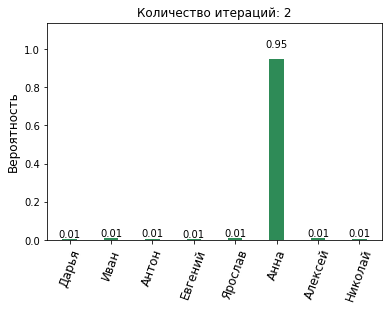

Имя: Анна
Номер телефона: +54-51


In [151]:
result = execute(qc, backend='local_qasm_simulator',
                 shots=8192).result()
plot_histogram(result.get_counts(), title='Количество итераций: 2', name_mapping=name_mapping)

number, name = most_probable_result(result).split()
print('Имя:', name_mapping[name])
print('Номер телефона:', number_mapping[number])

In [187]:
n = 3  # Number of qubits.
n_iter = int(np.sqrt(n) + 1) # iterate sqrt(N) times

In [192]:
query_name = 'Иван'
query = name_mapping_inv[query_name]
query

'001'

In [ ]:
qc.

In [196]:
print(qc.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg fin[3];
creg ans[3];
qreg phone[3];
creg ansphone[3];
h fin[0];
h fin[1];
h fin[2];
x fin[1];
x fin[2];
h fin[0];
ccx fin[1],fin[2],fin[0];
h fin[0];
x fin[1];
x fin[2];
h fin[0];
h fin[1];
h fin[2];
x fin[0];
x fin[1];
x fin[2];
h fin[0];
ccx fin[1],fin[2],fin[0];
h fin[0];
x fin[0];
x fin[1];
x fin[2];
h fin[0];
h fin[1];
h fin[2];
x fin[1];
x fin[2];
h fin[0];
ccx fin[1],fin[2],fin[0];
h fin[0];
x fin[1];
x fin[2];
h fin[0];
h fin[1];
h fin[2];
x fin[0];
x fin[1];
x fin[2];
h fin[0];
ccx fin[1],fin[2],fin[0];
h fin[0];
x fin[0];
x fin[1];
x fin[2];
h fin[0];
h fin[1];
h fin[2];
cx fin[0],phone[0];
cx fin[1],phone[1];
cx fin[2],phone[2];
measure fin[0] -> ans[0];
measure fin[1] -> ans[1];
measure fin[2] -> ans[2];
measure phone[0] -> ansphone[0];
measure phone[1] -> ansphone[1];
measure phone[2] -> ansphone[2];



Поиск номера по имени: "Иван" -> "001"


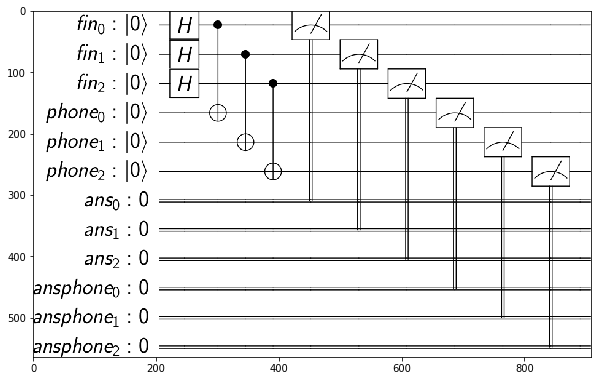

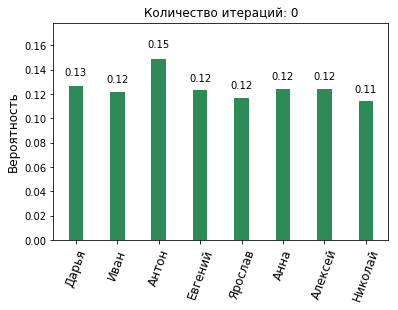

Имя: "010" -> "Антон"
Номер телефона: +25-47

=== === ===



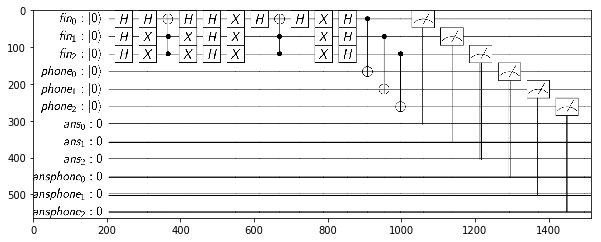

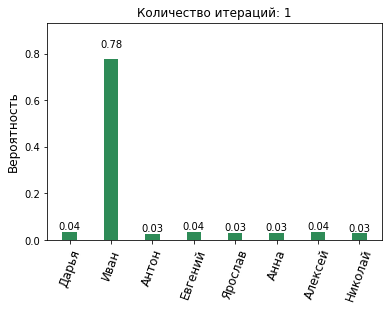

Имя: "001" -> "Иван"
Номер телефона: +48-92

=== === ===



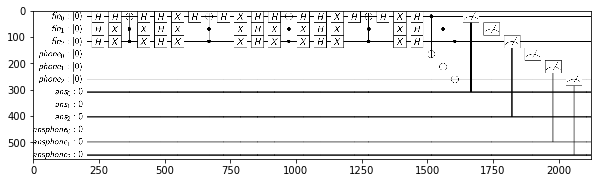

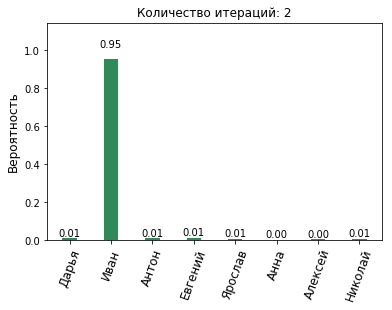

Имя: "001" -> "Иван"
Номер телефона: +48-92

=== === ===



In [193]:
assert n == len(query)

shots = 1000

print('Поиск номера по имени: "{}" -> "{}"'.format(query_name, query))

for i in range(n_iter + 1):
    qc = utils.build_grover_search_qc(n, i, query)

    phone = QuantumRegister(n, name='phone')
    qc.add(phone)
    ansphone = ClassicalRegister(n, name='ansphone')
    qc.add(ansphone)

    qc.cx(qc.get_qregs()['fin'], qc.get_qregs()['phone'])

    qc.measure(qc.get_qregs()['fin'], qc.get_cregs()['ans'])
    qc.measure(qc.get_qregs()['phone'], qc.get_cregs()['ansphone'])
    
    plt.figure(figsize=(10,10))
    im = circuit_drawer(qc)
    plt.imshow(im)
    plt.show()
    
    result = execute(qc, backend='local_qasm_simulator', shots=shots).result()
    plot_histogram(result.get_counts(), title='Количество итераций: {}'.format(i),
                   name_mapping=name_mapping)

    number, name = most_probable_result(result).split()
    print('Имя: "{}" -> "{}"'.format(name, name_mapping[name]))
    print('Номер телефона:', number_mapping[number])
    
    print('')
    print('=== === ===')
    print('')

# Grover only

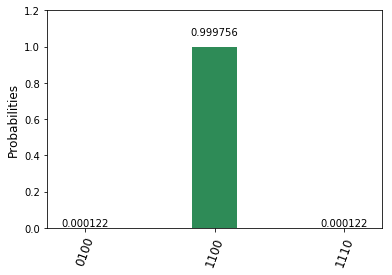

In [85]:
#qc.measure(f_in, ans)
problem = execute(qc, backend='local_qasm_simulator', shots=8192)
print(problem)
result = problem.result()
counts = result.get_counts()
plot_histogram(counts)
result

# k-SAT

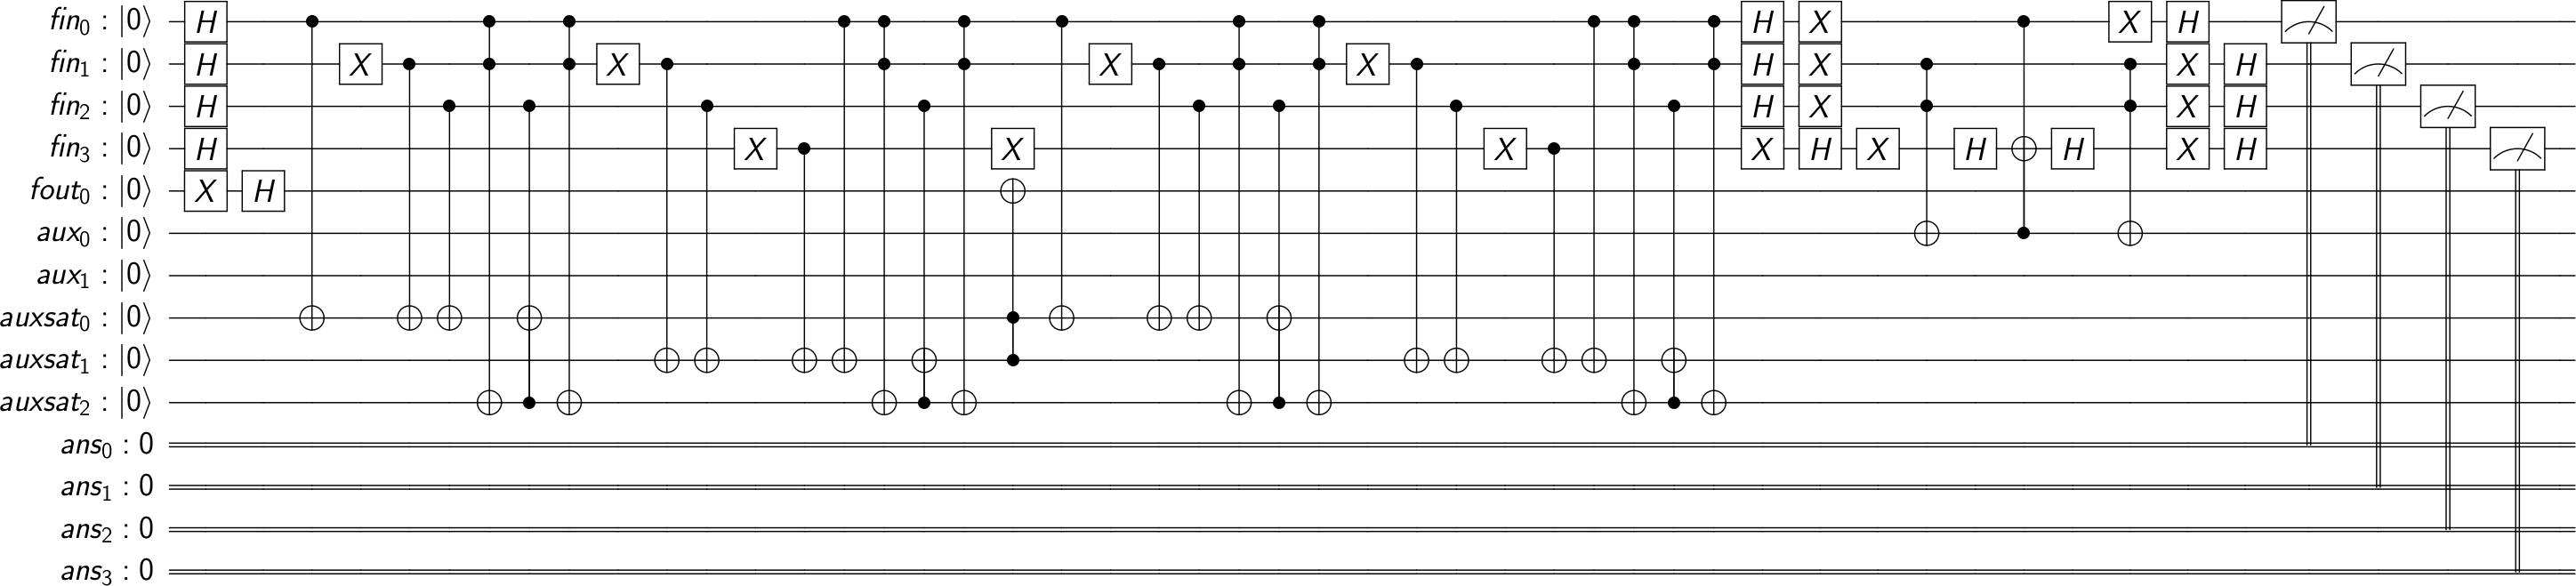

In [69]:
n = 4  # Number of qubits.
sat_formula = [[1, -2, 3], [2, 3, -4, 1]]

f_in = QuantumRegister(n, name='fin')
f_out = QuantumRegister(1, name='fout')
aux_sat = QuantumRegister(len(sat_formula) + 1, name='auxsat')
ans = ClassicalRegister(n, name='ans')

n_controls = n

aux = None
qc = None
if n_controls > 2:
    aux = QuantumRegister(n_controls - 2, name='aux')
    qc = QuantumCircuit(f_in, f_out, aux, aux_sat, ans, name='grover')
else:
    qc = QuantumCircuit(f_in, f_out, aux_sat, ans, name='grover')

input_state(qc, f_in, f_out)
black_box_u_f(qc, f_in, f_out, aux_sat, n, sat_formula)
inversion_about_average(qc, f_in, aux, n)

qc.measure(f_in, ans)

circuit_drawer(qc)

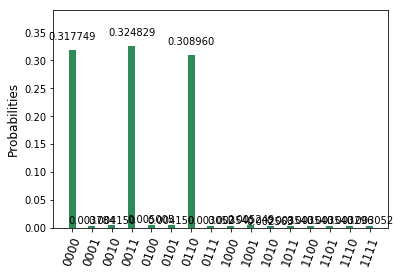

In [70]:
result = execute(qc, backend='local_qasm_simulator', shots=8192).result()
counts = result.get_counts('grover')
plot_histogram(counts)